## Anderson Monken
## December 11, 2020
## News data processing and graph production

In [1]:
import os
from striprtf.striprtf import rtf_to_text
import pandas as pd
from dateutil.parser import parse
import seaborn as sns
import plotly.graph_objects as go

In [2]:
def article_file_process(file_name):
    """ Process the raw rtf file and output list of articles """
    
    # open and set up article into list of text lines
    rtftext = open(file_name,'r').read()
    rawtext = rtf_to_text(rtftext)
    rawtextlines = rawtext.split('\n')

    # empty list and starter variables for the looping
    article_list = [None] * 200
    count = 0
    article_line_count = 0
    article_list[count] = {'rawtext' : [],
                           'docid' : None,
                           'metadata' : []}
    article_meta = True

    # loop through lines of the raw text
    for line in rawtextlines:
        
        # this section is when we're at the end of the document, we don't care about the summary
        if line == "Search Summary":
            break
        
        # this is the start of a new article
        elif line.find('Document ') != -1:
            #print(f'article {count}: {line}')
            article_list[count]['docid'] = line
            count += 1

            article_list[count] = {'rawtext' : [],
                                   'docid' : None,
                                   'metadata' : []}
            article_meta = True
            article_line_count = 0
            
        # this is a continuing article from the last doc line
        # store the result in the text or metadata line based if we hit the copyright line or not
        else:
            article_line_count += 1
            if article_line_count < 20 and article_meta == True:
                article_list[count]['metadata'].append(line)

                if line.startswith('Copyright'):
                    article_meta = False
            else:
                article_list[count]['rawtext'].append(line)

    # return all valid results
    return [x for x in article_list if x is not None]

In [3]:
# Execute processing function on all the raw text files
results = []
for file_i in os.listdir('.'):
    if file_i.endswith('.rtf'):
        print(file_i)
        results.append(article_file_process(file_i))

# flatten result to single list
article_results = [x for result_i in results for x in result_i]

Factiva-20201118-2217.rtf
Factiva-20201118-2223(1).rtf
Factiva-20201118-2223.rtf
Factiva-20201118-2224.rtf
Factiva-20201118-2225.rtf
Factiva-20201118-2226.rtf
Factiva-20201118-2227.rtf
Factiva-20201118-2228(1).rtf
Factiva-20201118-2228.rtf
Factiva-20201118-2229.rtf
Factiva-20201118-2231.rtf
Factiva-20201118-2232.rtf
Factiva-20201118-2233.rtf
Factiva-20201118-2234.rtf
Factiva-20201118-2235.rtf
Factiva-20201118-2236(1).rtf
Factiva-20201118-2236.rtf
Factiva-20201118-2237.rtf
Factiva-20201118-2238.rtf
Factiva-20201118-2239(1).rtf
Factiva-20201118-2239.rtf
Factiva-20201118-2240.rtf
Factiva-20201118-2241(1).rtf
Factiva-20201118-2241.rtf
Factiva-20201118-2242.rtf
Factiva-20201118-2243.rtf
Factiva-20201118-2244.rtf
Factiva-20201118-2245.rtf
Factiva-20201118-2246(1).rtf
Factiva-20201118-2246.rtf


In [4]:
# turn into pandas dataframe for ease of processing
df = pd.DataFrame(article_results)
df.columns

Index(['rawtext', 'docid', 'metadata'], dtype='object')

In [5]:
# filter out invalid entries
df = df[[x is not None for x in df.docid]]
df = df[df['rawtext'].apply(lambda x: len(x)) > 0]

In [6]:
def source_identify(item):
    """ Function to determine if article is NYTimes or WSJ based on metadata"""
    ny_times = any([True if x.find('The New York Times') != -1 else False for x in item])
    wsj = any([True if x.find('Wall Street Journal') != -1 else False for x in item])

    if ny_times == True and wsj == True:
        print("Double identification issue")
    elif ny_times == True:
        return 'NY Times'
    elif wsj == True:
        return 'WSJ'
    else:
        print("No identification issue")
        print(ny_times, wsj)

def soft_parse(x):
    """ Try to parse date without erroring"""
    try:
        return parse(x)
    except:
        return None
    
def get_date(item):
    """ Process all metadata lines and catch the first date for the dataframe """
    result = [soft_parse(x) for x in item]
    dates = [x for x in result if x is not None]
    return dates[0]  
    

In [7]:
df['publication'] = df['metadata'].apply(source_identify)
df['article_date'] = df.metadata.apply(get_date)

In [8]:
# join text into single field
df['text'] = df.rawtext.apply(lambda x: ' '.join(x))

In [9]:
df['text']

0        To the Editor:  Re ''F.B.I. Says Review Clear...
1        Never mind.  That was the message James Comey...
2        The current election -- regardless of its out...
3        Shortly after the curtain fell on the 1976 el...
4        CORRECTION APPENDEDCOLUMBUS, Ohio -- Sixteen ...
                              ...                        
2992     Your editorial calls the Libertarian Party's ...
2993     ANAHEIM, Calif. -- DURING the final days of a...
2994     LOS ANGELES -- THIS is a town where scripts r...
2995     Each Saturday, Farhad Manjoo and Mike Isaac, ...
2996     TUCSON, Ariz. -- Senator John McCain does not...
Name: text, Length: 2967, dtype: object

In [10]:
#df['token_text'] = df['text'].swifter.apply(lambda x: [token for token in nlp.tokenizer(x.strip()) if not token.is_stop])

In [11]:
df = df.reset_index(drop = True)

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [13]:
sid = SentimentIntensityAnalyzer()

In [14]:
df['sentiment'] = df.text.apply(lambda x: sid.polarity_scores(x))

In [15]:
df['neg_score'] = df['sentiment'].apply(lambda x: x['neg'])
df['pos_score'] = df['sentiment'].apply(lambda x: x['pos'])

In [16]:
import plotly.express as px

In [17]:
df.columns

Index(['rawtext', 'docid', 'metadata', 'publication', 'article_date', 'text',
       'sentiment', 'neg_score', 'pos_score'],
      dtype='object')

In [34]:
df_date = df.groupby(['article_date','publication'])['neg_score','pos_score'].mean().reset_index()
df_date_count = df.groupby(['article_date','publication'])['rawtext'].count().reset_index()

<ipython-input-34-ad56982355fd>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [35]:
df_date['diff'] = df['neg_score'] - df['pos_score']
df_ma14 = df_date.set_index('article_date').groupby('publication').rolling(window=14).mean().reset_index()
df_ma14[['neg_score','pos_score']] = round(df_ma14[['neg_score','pos_score']],4)

In [127]:
fig = px.line(df_ma14, 
        x = 'article_date', 
        y = 'neg_score', 
        color = 'publication',
        template='simple_white',
        labels={"article_date": "Date (14 day moving average)",
                "neg_score": "Average VADER Negative Sentiment Score",
                "publication": "Publication"},
        title="Negative sentiment of 2016 U.S. Presidential election articles by publication",
        color_discrete_map={"NY Times": "steelblue", "WSJ": "red"})
fig.add_shape(type="line",
    x0='2016-07-21', y0=df_ma14.neg_score.min(), x1='2016-07-21', y1=0.08,
    line=dict(color="red",width=3, dash = 'dot')
)
fig.add_shape(type="line",
    x0='2016-07-28', y0=df_ma14.neg_score.min(), x1='2016-07-28', y1=0.08,
    line=dict(color="blue",width=3, dash = 'dot')
)
fig.add_shape(type="line",
    x0='2016-10-28', y0=df_ma14.neg_score.min(), x1='2016-10-28', y1=0.08,
    line=dict(color="blue",width=3, dash = 'dot')
)
fig.add_trace(go.Scatter(
    x=['2016-07-11', '2016-08-08', '2016-10-21'],
    y=[0.08, 0.08, 0.081],
    text=["RNC Closing Night",
          "DNC Closing Night",
          "Comey Email Speech"],
    mode="text",
    hoverinfo='none'
))
fig.add_annotation(text="Source: Factiva News, author calculations",
                  xref="paper", yref="paper",
                  x=0, y=-0.22, showarrow=False)

fig.write_html('plotly_negsentiment.html')

In [128]:
fig = px.line(df_ma14, 
        x = 'article_date', 
        y = 'pos_score', 
        color = 'publication',
        template='simple_white',
        labels={"article_date": "Date (14 day moving average)",
        "pos_score": "Average VADER Positive Sentiment Score",
        "publication": "Publication"},
        title="Positive sentiment of 2016 U.S. Presidential election articles by publication",
        color_discrete_map={"NY Times": "steelblue", "WSJ": "red"})

fig.add_shape(type="line",
    x0='2016-07-21', y0=df_ma14.pos_score.min(), x1='2016-07-21', y1=0.103,
    line=dict(color="red",width=3, dash = 'dot')
)
fig.add_shape(type="line",
    x0='2016-07-28', y0=df_ma14.pos_score.min(), x1='2016-07-28', y1=0.103,
    line=dict(color="blue",width=3, dash = 'dot')
)
fig.add_shape(type="line",
    x0='2016-10-28', y0=df_ma14.pos_score.min(), x1='2016-10-28', y1=0.103,
    line=dict(color="blue",width=3, dash = 'dot')
)
fig.add_trace(go.Scatter(
    x=['2016-07-11', '2016-08-08', '2016-10-21'],
    y=[0.103, 0.103, 0.104],
    text=["RNC Closing Night",
          "DNC Closing Night",
          "Comey Email Speech"],
    mode="text",
    hoverinfo='none'
))
fig.add_annotation(text="Source: Factiva News, author calculations",
                  xref="paper", yref="paper",
                  x=0, y=-0.22, showarrow=False)
fig.write_html('plotly_possentiment.html')

### TF-IDF calculation

In [38]:
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import re
porter = PorterStemmer()
stop_words = stopwords.words('english') + ['mr','said','would']
import matplotlib.pyplot as plt

In [39]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # tokenize
    tokenized_sentence = word_tokenize(sentence.lower())
    
    # remove stop words and stem
    token_words = [porter.stem(w) for w in tokenized_sentence if not w in stop_words]  
    token_words = [w for w in token_words if not w in stop_words]  
    return ' '.join(token_words)

In [40]:
df['nltk_text'] = df['text'].apply(lambda x: preprocess_text(x))

In [41]:
sk_tfidf = TfidfVectorizer()

In [42]:
vectors = sk_tfidf.fit_transform(df['nltk_text'])
feature_names = sk_tfidf.get_feature_names()
denselist = vectors.todense().tolist()

In [43]:
matrix_tfidf = pd.DataFrame(denselist, columns=feature_names)

In [44]:
matrix_tfidf

,aaa,aacm,aardvark,aaron,aaronkaterski,aarp,aasif,ab,aba,ababa,...,zuleeg,zulfikar,zuma,zumbrun,zur,zurich,zverev,zvi,zvia,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_tfidf = matrix_tfidf.set_index(df['publication'])

In [46]:
words_tfidf = df_tfidf.groupby(level = 0).mean().stack().reset_index()

In [47]:
words_tfidf

,publication,level_1,0
0,NY Times,aaa,0.000014
1,NY Times,aacm,0.000015
2,NY Times,aardvark,0.000049
3,NY Times,aaron,0.000334
4,NY Times,aaronkaterski,0.000037
...,...,...,...
60315,WSJ,zurich,0.000036
60316,WSJ,zverev,0.000000
60317,WSJ,zvi,0.000000
60318,WSJ,zvia,0.000000


In [48]:
words_tfidf.columns = ['Publication','word_input','mean_tfidf']

In [80]:
top_tfidf = words_tfidf.set_index('word_input').groupby('Publication').mean_tfidf.nlargest(20).reset_index()

In [81]:
top_tfidf[top_tfidf['word_input'] == 'email']

,Publication,word_input,mean_tfidf


In [84]:
top_tfidf.to_csv('tfidf.csv')

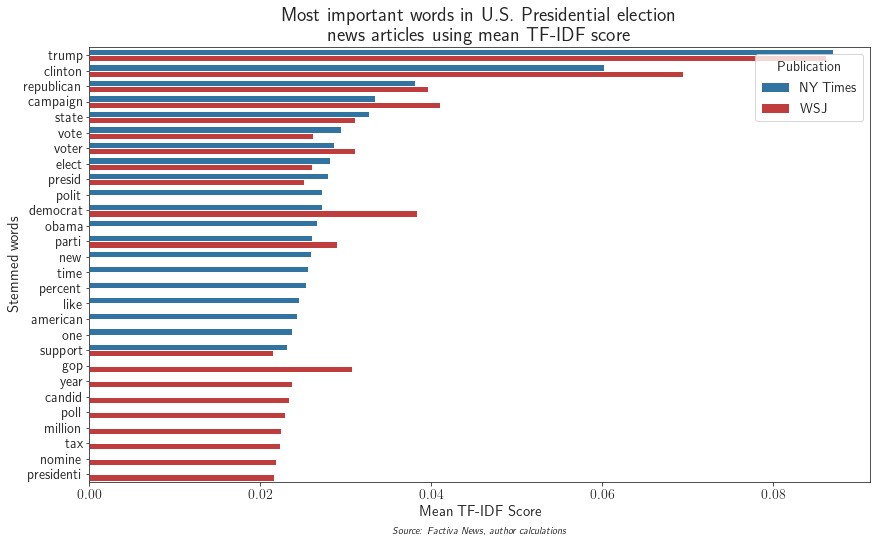

In [126]:
from matplotlib import rc
import matplotlib.pyplot as plt
import pandas as pd
top_tfidf = pd.read_csv('tfidf.csv')
rc('text', usetex=True)
fig = plt.figure(figsize=(14,8))
#sns.set_palette([sns.color_palette()[0],sns.color_palette()[3]])
with sns.axes_style("ticks"):
    sns.barplot(data = top_tfidf, x = 'mean_tfidf', y = 'word_input', hue ='Publication')
    plt.title("Most important words in U.S. Presidential election\nnews articles using mean TF-IDF score", fontsize = 20)
    plt.ylabel('Stemmed words')
    plt.xlabel(r'\begin{center}Mean TF-IDF Score\\*\textit{\normalsize{' + 'Source: Factiva News, author calculations' + r'}}\end{center}')
    #plt.show()
    
    SMALL_SIZE = 14
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig.savefig('test.png', dpi = 600)

## Bigram network diagram

In [ ]:
# reference from this site that walks through bi-gram analysis 
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

In [107]:
from nltk import bigrams
import itertools
import collections
import networkx as nx

In [109]:
# get list of articles for nytimes
list_articles_nytimes = df[df['publication'] == 'NY Times']['nltk_text'].apply(lambda x: x.split(' ')).tolist()
# list of bigrams
list_bigrams_nytimes = [list(bigrams(tweet)) for tweet in list_articles_nytimes]
# flatten list of bigrams
terms_bigram_nytimes = list(itertools.chain(*list_bigrams_nytimes))
# count bigrams across corpus
bigram_counts_nytimes = collections.Counter(terms_bigram_nytimes)
# select top 20
top_bigrams_nytimes = bigram_counts_nytimes.most_common(20)
# make a df
bigram_df_nytimes = pd.DataFrame(top_bigrams_nytimes, columns=['bigram', 'count'])

In [110]:
# get list of articles for wsj
list_articles_wsj = df[df['publication'] == 'WSJ']['nltk_text'].apply(lambda x: x.split(' ')).tolist()
# list of bigrams
list_bigrams_wsj = [list(bigrams(tweet)) for tweet in list_articles_wsj]
# flatten list of bigrams
terms_bigram_wsj = list(itertools.chain(*list_bigrams_wsj))
# count bigrams across corpus
bigram_counts_wsj = collections.Counter(terms_bigram_wsj)
# select top 20
top_bigrams_wsj = bigram_counts_nytimes.most_common(20)
# make a df
bigram_df_wsj = pd.DataFrame(top_bigrams_wsj, columns=['bigram', 'count'])

In [111]:
d = bigram_df_wsj.set_index('bigram').T.to_dict('records')

In [113]:
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

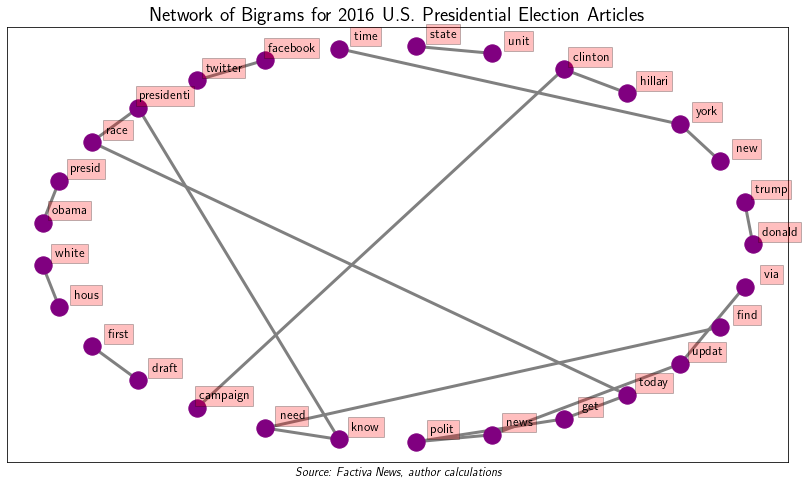

In [138]:
fig, ax = plt.subplots(figsize=(14, 8))

#pos = nx.spring_layout(G, k=1.5)
pos = nx.circular_layout(G)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.075, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.title('Network of Bigrams for 2016 U.S. Presidential Election Articles', fontsize = 20)
plt.xlabel(r'\begin{center}\textit{\large{' + 'Source: Factiva News, author calculations' + r'}}\end{center}')
#plt.show()
fig.savefig('bigrams.png', dpi = 600)

## Machine Learning Section (not used)

In [41]:
max_len_message = 2000
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import datetime
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
tfkl = tfk.layers

keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(df['nltk_text'].values)
vocab = keras_tokenizer.index_word
X = keras_tokenizer.texts_to_sequences(df['nltk_text'].values)
X = pad_sequences(X, maxlen=max_len_message, padding='post')

In [42]:
X

array([[  493,   494,    22, ...,     0,     0,     0],
       [  141,   561,   265, ...,     0,     0,     0],
       [  508,     6,  1992, ...,     0,     0,     0],
       ...,
       [ 1559,  1430,   783, ...,     0,     0,     0],
       [  655,  6110, 14681, ...,     0,     0,     0],
       [ 6645,  3928,    35, ...,     0,     0,     0]])

In [43]:
# split the data into three categories: train section for training model, 
# validation section for checking progress at each epoch
# and test section for checking final performance of model
X_train, X_test, y_train, y_test \
    = train_test_split([x for x in range(X.shape[0])], 
                       df['pub_nytimes'].values, 
                       test_size=0.15, 
                       random_state=2452,
                       stratify = df['pub_nytimes'].values)

# X_train, X_val, y_train, y_val \
#     = train_test_split([x for x in range(len(X_train))], 
#                        y_train, 
#                        test_size=0.05, 
#                        random_state=764,
#                        stratify = y_train)


In [44]:
train_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_train,:], tf.uint32), tf.cast(y_train, tf.uint8))
                )
             .batch(32).repeat()
             )
test_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_test,:], tf.uint32), tf.cast(y_test, tf.uint8))
                )
             .batch(len(y_test)).repeat()
             )
# val_tfdf = (  tf.data.Dataset.from_tensor_slices(
#                    (tf.cast(X[X_val,:], tf.uint32), tf.cast(y_val, tf.uint8))
#                 )
#              .batch(len(y_val)).repeat()
#              )

In [45]:
rnn_model = tfk.Sequential([
    tfkl.Embedding(input_dim=len(vocab)+1, output_dim=16, input_length=max_len_message),
    tfkl.Bidirectional(tfkl.LSTM(100)),
    tfkl.Dropout(0.25),
    tfkl.Dense(1,activation="sigmoid")
])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 16)          482848    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               93600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 576,649
Trainable params: 576,649
Non-trainable params: 0
_________________________________________________________________


In [46]:
rnn_model.compile(loss=tfk.losses.BinaryCrossentropy(), 
                  metrics=[tfk.metrics.BinaryAccuracy()],
                  optimizer=tfk.optimizers.Adam()
                 )
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [47]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [48]:
results = rnn_model.fit(train_tfdf, steps_per_epoch=200, epochs=10,
                          validation_data = test_tfdf,
                          validation_steps = 1,
          callbacks=[tensorboard_callback])

Epoch 1/10


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Adam/Adam/update/AssignSubVariableOp/_41}}]]
	 [[gradient_tape/sequential/embedding/embedding_lookup/Reshape/_38]] [Op:__inference_train_function_5761]

Function call stack:
train_function


In [ ]:
y_pred_keras = rnn_model.predict(X[X_test,:]).ravel()
fpr_keras_rnn, tpr_keras_rnn, thresholds_keras_rnn = roc_curve(y_test, y_pred_keras)
auc_keras_rnn = auc(fpr_keras_rnn, tpr_keras_rnn)

In [ ]:
acc = results.history['binary_accuracy']
val_acc = results.history['val_binary_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Training + Validation Loss
plt.plot( epochs, loss, 'bo', label = 'Training Loss')
plt.plot( epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_rnn, tpr_keras_rnn, label='LSTM word sequence (area = {:.3f})'.format(auc_keras_rnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()